Load the image

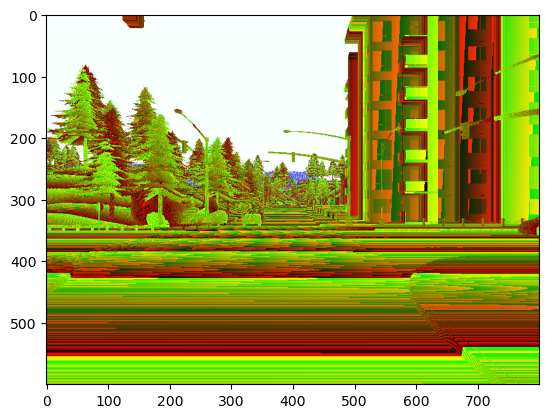

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
import MapToGrid as m2g
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D

#Define inverse camera transformation
def get_point_image(point_img,K_inv,Width,Height):
        loc_mat=np.zeros([Height,Width,3])
        static_projection_matrix=np.zeros([Height,Width,3])
        for i in range(Height):
                for j in range(Width):
                        loc_mat[i,j] = [j-Width/2,i-Height/2,1]
                        static_projection_matrix[i,j]=np.dot(K_inv,loc_mat[i,j])
        return static_projection_matrix , loc_mat


# Read Images
img = mpimg.imread('Rubens test files/Pictures/depth_003186.png') #to check the picture
img2 = mpimg.imread('Rubens test files/Pictures/instance_003186.png')
depth_data=plt.imread('Rubens test files/Pictures/depth_003186.png') #to get the data as an array
segment_data=plt.imread('Rubens test files/Pictures/instance_003186.png') #to get the data as an array
# Output Images
plt.imshow(img)
#plt.imshow(img2)



Initiate variables

In [2]:
depth_Width=depth_data[1,:,0].size
depth_Height=depth_data[:,1,0].size
print([depth_Height,depth_Width])

segment_Width=round(segment_data[1,:,0].size/3)
segment_Height=round(segment_data[:,1,0].size/3)


converted_depth_data=np.zeros([depth_Width,depth_Height])
segment_data=np.round(segment_data*255)


max_sensor_range= 0.4 #in kilometers
scale_factor=256

#convert depth units
R=depth_data[:,:,0]
G=depth_data[:,:,1]
B=depth_data[:,:,2]

normalized = ((R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1))*1000*scale_factor

#calculate projection matrix
fov = 90
im_size_x = 800
im_size_y = 600

f  = im_size_x /(2.0 * math.tan(fov * math.pi / 360))
Cx = im_size_x / 2.0
Cy = im_size_y / 2.0

K = np.array([[f, 0, Cx], [0, f, Cy], [0, 0, 1]], dtype=np.float64)
K_inv=np.linalg.inv(K)

[rel_coords,camera_index_mat]=get_point_image(normalized,K_inv,depth_Width,depth_Height)

[600, 800]


Calculate costmap


C:\Users\pepij\AppData\Local\Temp\ipykernel_7888\384196176.py:19: RuntimeWarning: invalid value encountered in sqrt
  z= np.sqrt(np.power(normalized,2)-np.power(x,2)-np.power(y,2)) #This loses some values but i cannot figure out why.


(0.0, 100.0)

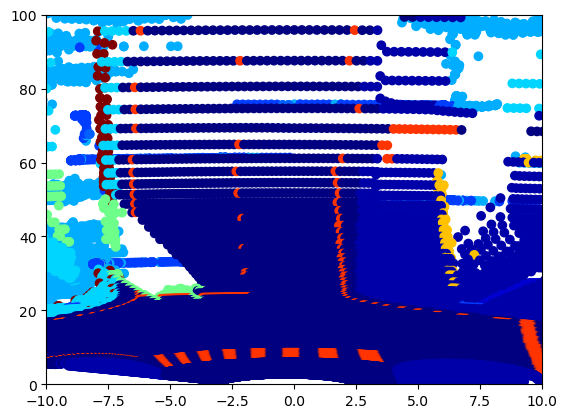

In [3]:
#we use np.division to quickly do elementwise matrix division where dividing by 0 equals 0

focal_mat=np.ones_like(rel_coords[:,:,0])
camera_index_mat=rel_coords

c_squared=np.square(focal_mat)+np.square(camera_index_mat[:,:,1])
d=np.power(np.square(camera_index_mat[:,:,0])+c_squared, 0.5*np.ones_like(camera_index_mat[:,:,0]))

#Create a condition to bypass the division incase of zeros
condition= (np.square(camera_index_mat[:,:,0]) + np.square(camera_index_mat[:,:,1]))!=0

#cant put a scalar in np.divide so we use ones
placeholder=np.ones_like(camera_index_mat[:,:,0])

a  = np.divide(placeholder, d, out=np.zeros_like(placeholder), where= condition)

x= a*normalized*(camera_index_mat[:,:,0]+1)*2
y= a*normalized*(camera_index_mat[:,:,1]+.75)
z= np.sqrt(np.power(normalized,2)-np.power(x,2)-np.power(y,2)) #This loses some values but i cannot figure out why.

#Visualize
plt.scatter(x,z,c=segment_data[:,:,0],cmap='jet')
plt.xlim(-10,10)
plt.ylim(0,100)

In [4]:
import MapToGrid as m2g

#remove these after testing
reload(m2g)


x[np.isnan(x)==True]=0
y[np.isnan(y)==True]=0
z[np.isnan(z)==True]=0

# fig=plt.figure()
# ax=fig.add_subplot(projection='3d')
# ax.scatter(x,z,y,c=segment_data[:,:,0],cmap='jet')
# plt.xlim(-10,10)
# plt.ylim(0,100)

#todo: apply proper scaling 
#initiate grid 
map_width=120 
map_height=120*2
cell_size=0.1
costmap=np.zeros([int(map_width/cell_size),int(map_height/cell_size)])

#Cut out the usefull data we make it a 120m by 120m cube infront of the car
condition=((x>60) | (x<-60) | (z<0) | (z>120))
x[condition] = 0
y[condition] = 0
z[condition] = 0
print()

labels=segment_data[:,:,0]

# fig=plt.figure()
# ax=fig.add_subplot(projection='3d')
# ax.scatter(x,z,y,c=segment_data[:,:,0],cmap='jet')
# plt.xlim(-15,15)
# plt.ylim(0,100)

#transform to the grid 

# Call the updated map3grid function
cost_map = m2g.map3grid(costmap, x, z, labels, map_width, map_height, cell_size)
np.save(r'C:\Users\pepij\Documents\Master Year 1\Q3\5ARIP10 Interdisciplinary team project\costmap5.npy', cost_map)

#determine costs 

#add to previous existing costmap 

#add vehicle layers 

#calculate motion primitives

[0. 0. 0. ... 0. 0. 0.]


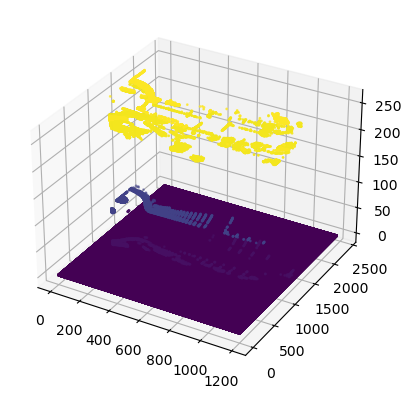

In [5]:
print(cost_map[3])
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
x_cost,y_cost=np.meshgrid(np.arange(len(cost_map[:,0])),np.arange(len(cost_map[0,:])))
ax.scatter(x_cost,y_cost,cost_map.flatten(),c=cost_map.flatten(),s=1)


In [6]:
print(np.size(cost_map))
print(np.count_nonzero(cost_map))
A=[-1,-5,0,-3,4]
print(np.count_nonzero(A))

2880000
67619
4


(-2.5, 2.5)

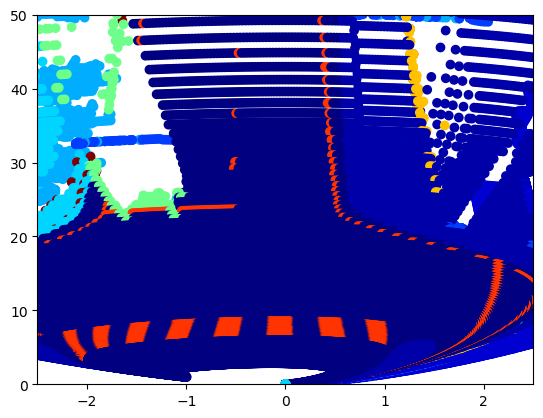

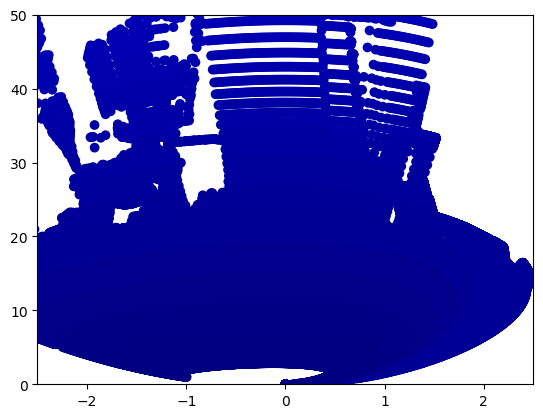

In [7]:
# Old plots I might keep for later
plt.scatter((camera_index_mat[:,:,0]+1)*np.power(z,2/3),z,c=segment_data[:,:,0],cmap='jet')
plt.ylim(0,50)
plt.xlim(-2.5,2.5)
#plt.xlim(0,-0.005)
#plt.ylim(0,1)
plt.figure()
plt.scatter((camera_index_mat[:,:,0]+1)*np.power(z,1/2),z,c=normalized,cmap='jet')
plt.ylim(0,50)
plt.xlim(-2.5,2.5)